In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


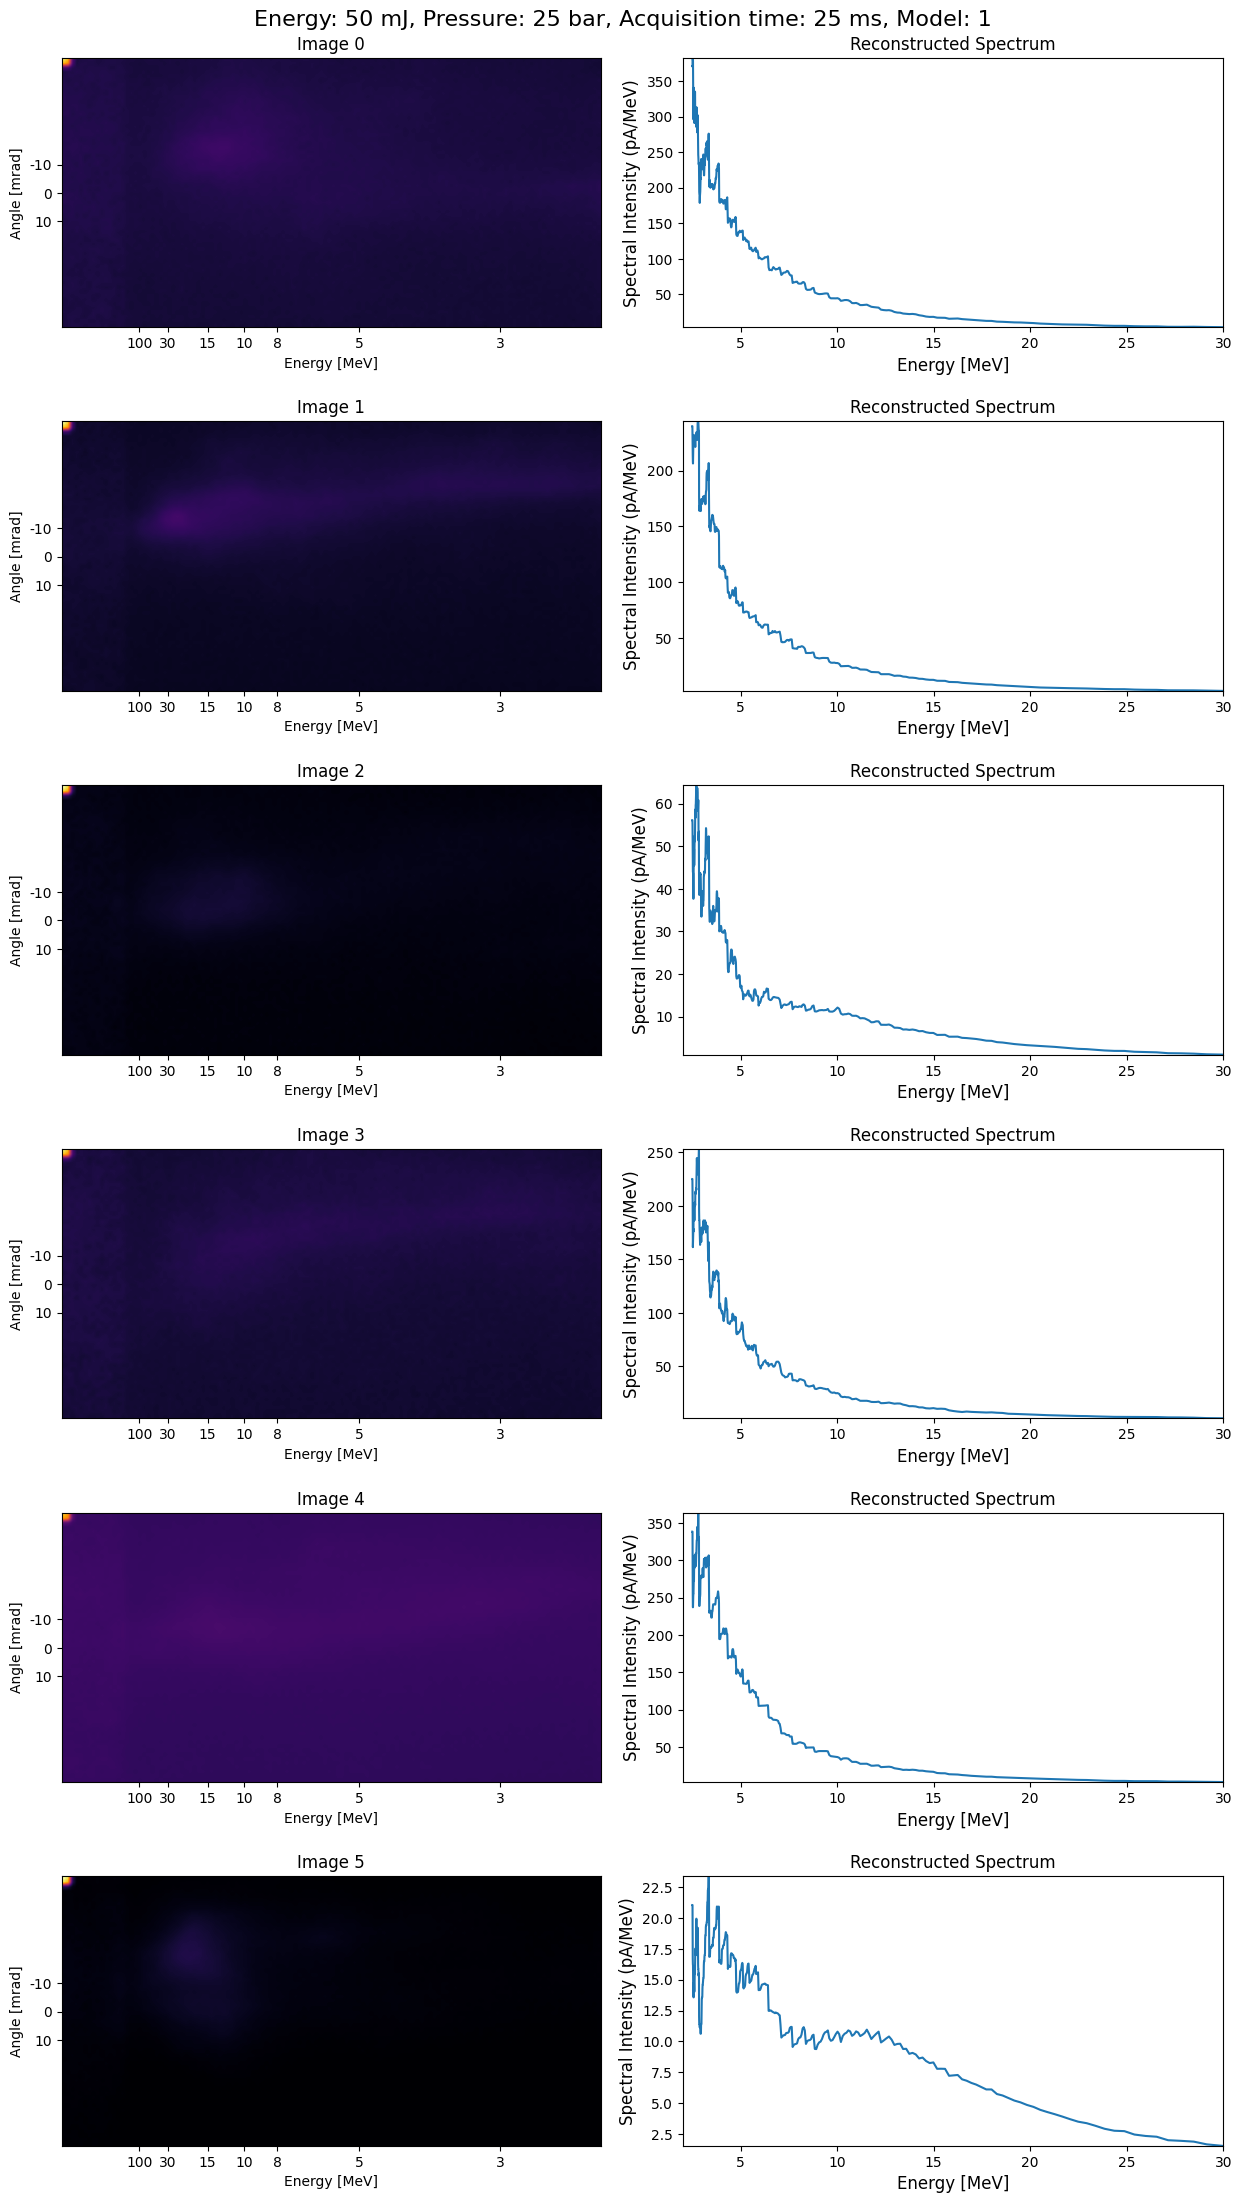

100%|██████████| 25/25 [00:03<00:00,  7.71it/s]


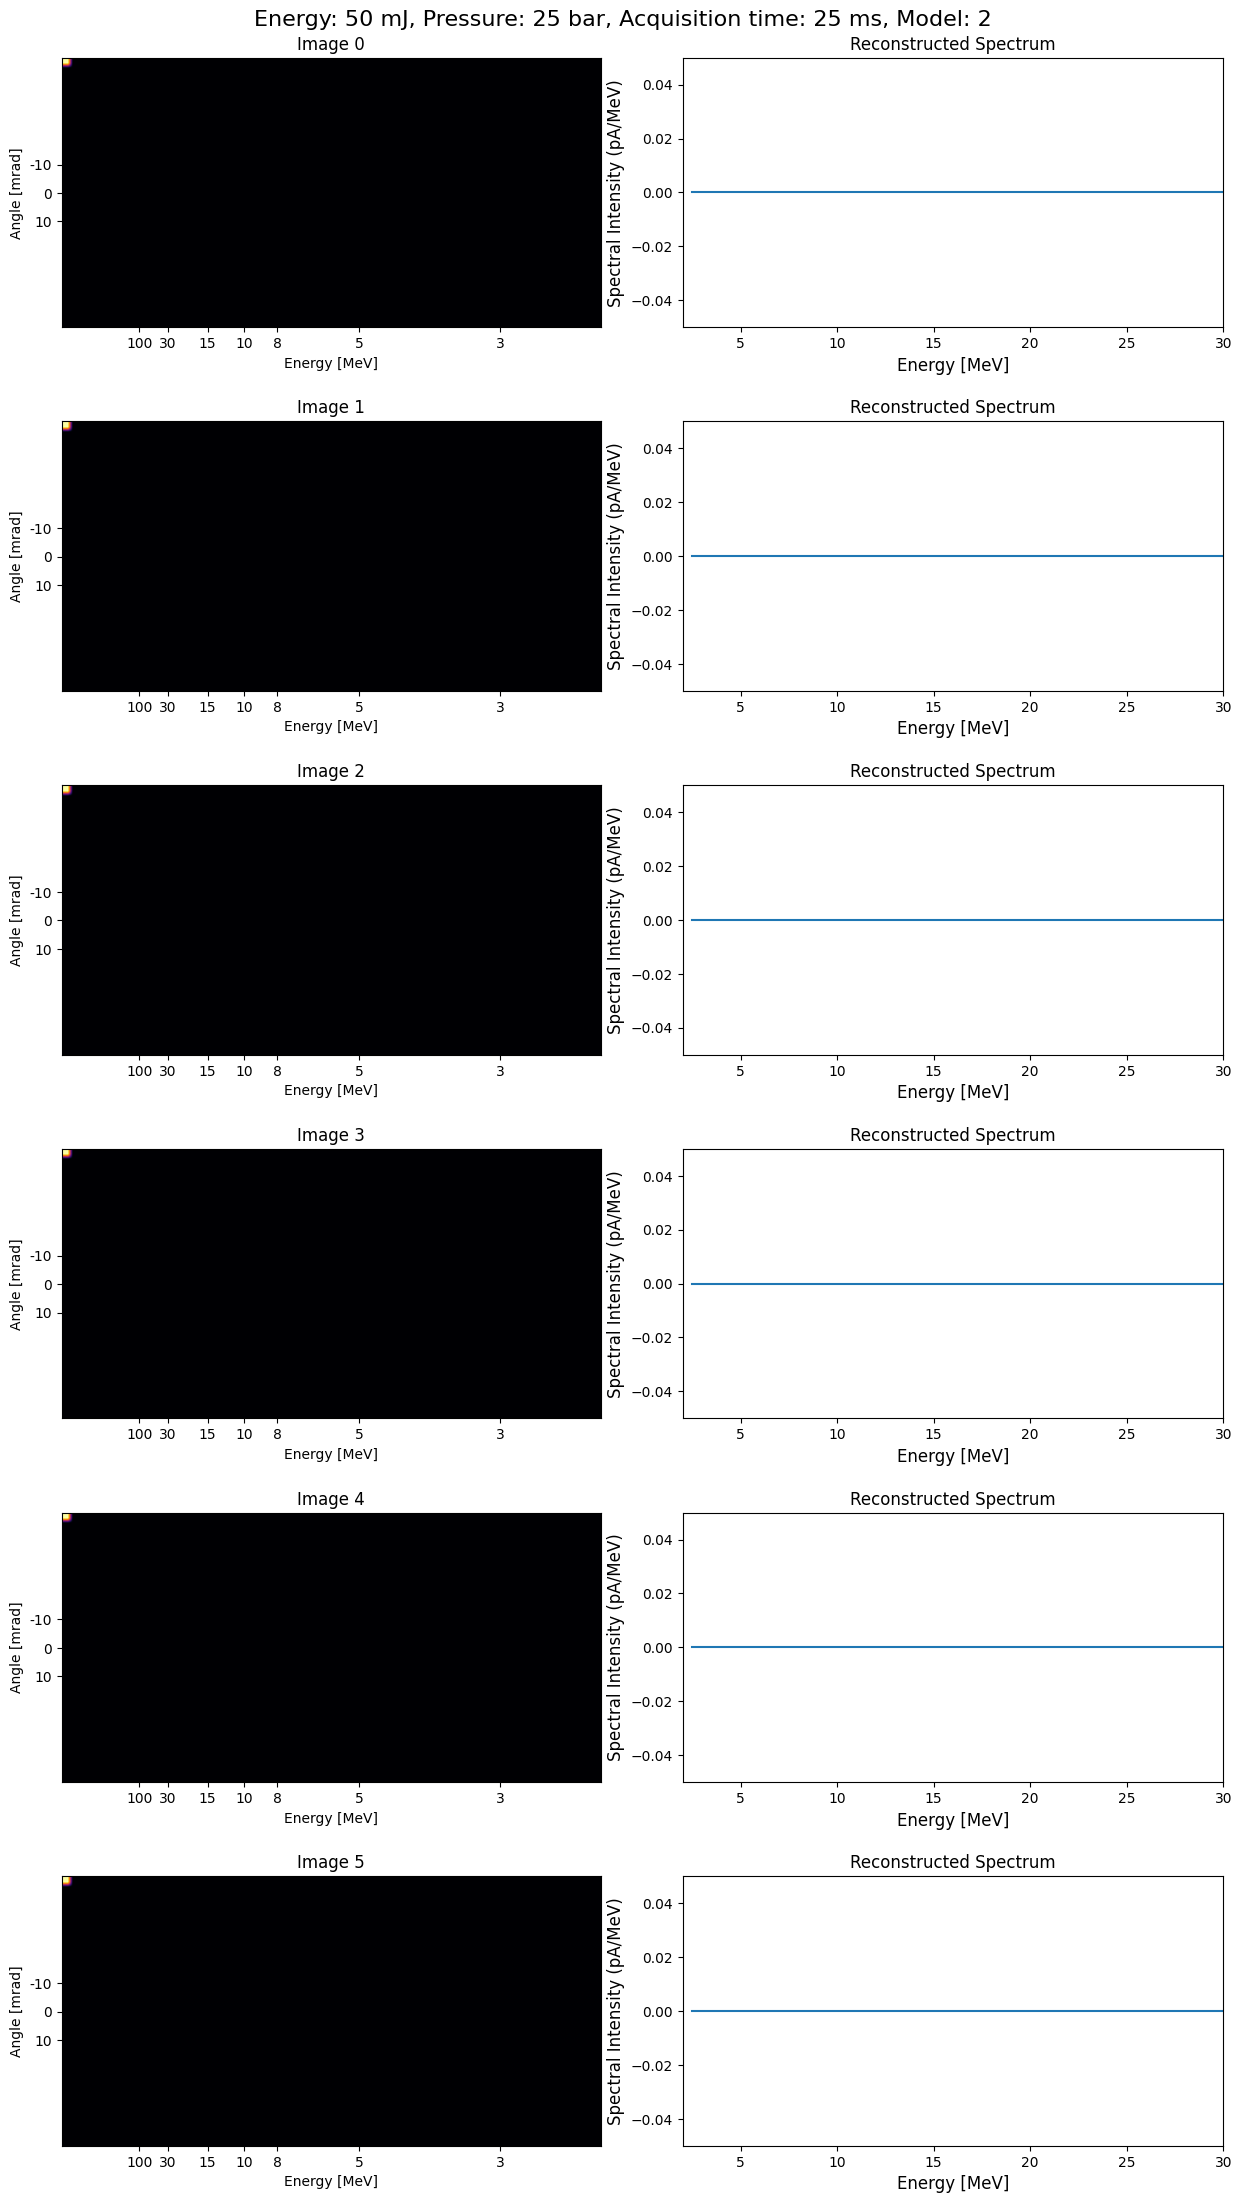

In [9]:
import torch
from src.diffusion import GaussianDiffusion, SpacedDiffusion
from src.modules import UNet_conditional
from src.utils import plot_images, plot_images_from_dir, plot_image_pairs, save_samples
# 32, 4, 15 - very dark
# 23, 25, 20 - switches between 2 types of images
# 32, 15, 10
# 15, 15, 20 - thin line
# 19, 15, 20 - thicker line, more up and bent
# 25, 15, 20 - blob on the left, vague line from it, noisy
# 25, 15, 40 - crazy bright smudge
# 15, 15, 100 - second model shows all near max value

# 15, 15, 1 - second model shows all black
n = 6
device = "cuda:1"
E = 50
P = 25
ms = 25

model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/1st_phys_spec_beam_850ns/ema_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)
sampler = SpacedDiffusion(beta_start=1e-4, beta_end=0.02, noise_steps=850, section_counts=[2, 2, 2, 2, 2, 2, 2, 2, 2, 7], img_height=64, img_width=128, device=device, rescale_timesteps=False)
y = torch.Tensor([E,P,ms]).to(device).float().unsqueeze(0) # parameter vector
x = sampler.ddim_sample_loop(model=model, y=y, cfg_scale=1, device=device, eta=1, n=n)
plot_image_pairs(x, xlim=[2,30], acquisition_time_ms=ms, beam_point_y=128, beam_point_x=62, energy=E, pressure=P, model=1)
# save_samples(x, folder="model1_medhigh")



model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/2nd_phys_spec_1000ns/ema_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)
sampler = SpacedDiffusion(beta_start=1e-4, beta_end=0.02, noise_steps=1000, section_counts=[2, 2, 2, 2, 2, 2, 2, 2, 2, 7], img_height=64, img_width=128, device=device, rescale_timesteps=False)
y = torch.Tensor([E,P,ms]).to(device).float().unsqueeze(0) # parameter vector
x = sampler.ddim_sample_loop(model=model, y=y, cfg_scale=3, device=device, eta=1, n=n)
plot_image_pairs(x, xlim=[2,30], acquisition_time_ms=ms, beam_point_y=128, beam_point_x=62, energy=E, pressure=P, model=2)
# save_samples(x, folder="model2_medhigh")

In [1]:
import torch
import time
import pandas as pd
from src.diffusion import GaussianDiffusion, SpacedDiffusion
from src.modules import UNet_conditional
from tqdm import tqdm

# Your setup code
device = "cuda:3"
E = 25
P = 15
ms = 10

ns = 850
model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/physinf_tenth_850ns/ema_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)

# Values for sections and n
sections_values = [15, 25, 45]
n_values = range(1, 21)

# Data collection
results = []

for n in n_values:
    for section in sections_values:
        sampler = SpacedDiffusion(beta_start=1e-4, beta_end=0.02, noise_steps=ns, section_counts=[section], img_height=64, img_width=128, device=device, rescale_timesteps=False)
        y = torch.Tensor([E, P, ms]).to(device).float().unsqueeze(0)  # parameter vector

        # Timing the execution
        start_time = time.time()
        x = sampler.ddim_sample_loop(model=model, y=y, cfg_scale=6, device=device, eta=1, n=n)
        end_time = time.time()

        # Calculating time per image
        time_per_image = (end_time - start_time) / n
        results.append([section, n, time_per_image])

# Convert results to a DataFrame and save as CSV
df = pd.DataFrame(results, columns=['Section', 'N', 'Time per Image (seconds)'])
df.to_csv('execution_time_analysis.csv', index=False)
print("CSV file saved: execution_time_analysis.csv")


/home/jechmate/anaconda3/envs/eli/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 45/45 [00:18<00:00,  2.47it/s]

CSV file saved: execution_time_analysis.csv


In [3]:
import torch
import time
import pandas as pd
from src.diffusion import GaussianDiffusion, prepare_noise_schedule
from src.modules import UNet_conditional

# Your setup code
device = "cuda:3"
E = 25
P = 15
ms = 20

model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/physinf_tenth_850ns/ema_ckpt.pt", map_location=device)
model.load_state_dict(ckpt)

# Values for noise_steps and n
noise_steps_values = [700, 850, 1000]
n_values = [20]

# Data collection
results = []

for noise_step in noise_steps_values:
    betas = prepare_noise_schedule(noise_steps=noise_step, beta_start=1e-4, beta_end=0.02)
    diffusion = GaussianDiffusion(betas=betas, img_width=128, img_height=64, device=device, noise_steps=noise_step)

    for n in n_values:
        y = torch.Tensor([E, P, ms]).to(device).float().unsqueeze(0)  # parameter vector

        # Timing the execution
        start_time = time.time()
        x = diffusion.sample_ddpm(model, n, y, cfg_scale=5, resize=[256, 512])
        end_time = time.time()

        # Calculating time per image
        time_per_image = (end_time - start_time) / n
        results.append([noise_step, n, time_per_image])

# Convert results to a DataFrame and save as CSV
df = pd.DataFrame(results, columns=['Noise Steps', 'N', 'Time per Image (seconds)'])
df.to_csv('execution_time_analysis_diffusion.csv', index=False)
print("CSV file saved: execution_time_analysis_diffusion.csv")


23it [00:10,  2.25it/s]


KeyboardInterrupt: 